In [2]:
import pandas as pd
import numpy as np
import math as mt
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sklearn.feature_extraction

In [4]:
import tldextract

In [5]:
from collections import Counter

In [6]:
# read the data.
alexa_data = pd.read_csv('alexa_100k.csv', header=None, encoding='utf-8', names=['rank', 'uri'])
alexa_data.head()

# Data before sanitization
print len(alexa_data)

100000


In [7]:
alexa_data.tail()

,rank,uri
99995,99996,rhbabyandchild.com
99996,99997,rm.com
99997,99998,sat1.ch
99998,99999,nahimunkar.com
99999,100000,musi.pk


In [8]:
# Extract top level domain.
def domaineExtract(uri):
    extract = tldextract.extract(uri)
    if not extract.suffix:
        return np.nan
    else:
        return extract.domain


In [9]:
''' Calculate the entropy of each domain '''
def entropy(uri):
    elements, lns = Counter(uri), float(len(uri))
    return -sum(element/lns * mt.log(element/lns, 2) for element in elements.values())


In [10]:
# Test doamin extract
test_domain = domaineExtract('https://www.google.com')

In [11]:
# Test doamin extract
test_domain = domaineExtract('https://www.google.com')
test_domain

'google'

In [12]:
alexa_data['domain'] = [domaineExtract(uri) for uri in alexa_data['uri']]
alexa_data.head()

,rank,uri,domain
0,1,facebook.com,facebook
1,2,google.com,google
2,3,youtube.com,youtube
3,4,yahoo.com,yahoo
4,5,baidu.com,baidu


In [13]:
# Need to check for NAs or duplicates.
alexa_data = alexa_data.dropna()
alexa_data = alexa_data.drop_duplicates()
print 'Data after sanitization ' + str(len(alexa_data))

Data after sanitization 99838


In [14]:
del alexa_data['rank']
del alexa_data['uri']
alexa_data.head()

,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [15]:
alexa_data['label'] = 'legit'
alexa_data.head()

,domain,label
0,facebook,legit
1,google,legit
2,youtube,legit
3,yahoo,legit
4,baidu,legit


In [16]:
''' Introduce some noise with ditchled, to reorder records in domains since they are ranked '''
alexa_data = alexa_data.reindex(np.random.permutation(alexa_data.index))
alexa_data.head()

,domain,label
28388,webmastertalkforums,legit
8003,ed4,legit
26683,mirathewalkingdead,legit
76068,ferplei,legit
85093,abdil,legit


In [17]:
# Read DGA data.
dga_domains = pd.read_csv('dga_domain.txt', header=None, encoding='utf-8', names=['domain'])
dga_domains.head()

,domain
0,04055051be412eea5a61b7da8438be3d.info
1,1cb8a5f36f.info
2,30acd347397c34fc273e996b22951002.org
3,336c986a284e2b3bc0f69f949cb437cb.info
4,336c986a284e2b3bc0f69f949cb437cb.org


In [18]:
print 'Length of the data before sanitization ' + str(len(dga_domains))

Length of the data before sanitization 2669


In [19]:
# Normalisation (strip and lowercase)
dga_domains['domain'] = dga_domains.applymap(lambda x: x.split('.')[0].strip().lower())
dga_domains.head()

,domain
0,04055051be412eea5a61b7da8438be3d
1,1cb8a5f36f
2,30acd347397c34fc273e996b22951002
3,336c986a284e2b3bc0f69f949cb437cb
4,336c986a284e2b3bc0f69f949cb437cb


In [20]:
# Sanitize the data.
dga_domains['domain'].dropna()
dga_domains['domain'].drop_duplicates()
print 'Length of the data after sanitization ' + str(len(dga_domains))

Length of the data after sanitization 2669


In [21]:
# Add dga label.
dga_domains['label'] = 'dga'
dga_domains.head()
dga_domains.head()

,domain,label
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
4,336c986a284e2b3bc0f69f949cb437cb,dga


In [22]:
# Concatenate the data all together.
all_domains = pd.concat([alexa_data, dga_domains], ignore_index=True)
all_domains.head()

,domain,label
0,webmastertalkforums,legit
1,ed4,legit
2,mirathewalkingdead,legit
3,ferplei,legit
4,abdil,legit


In [23]:
# Add length and entropy metrics.
all_domains['length'] = [len(x) for x in all_domains['domain']]
all_domains.head()

,domain,label,length
0,webmastertalkforums,legit,19
1,ed4,legit,3
2,mirathewalkingdead,legit,18
3,ferplei,legit,7
4,abdil,legit,5


In [24]:
''' It is said that domains with length less that 6 are very random, so we'll select ones greaster that 6 '''
all_domains = all_domains[all_domains['length'] > 6]
all_domains.head()

,domain,label,length
0,webmastertalkforums,legit,19
2,mirathewalkingdead,legit,18
3,ferplei,legit,7
5,bangbros1,legit,9
9,mygorod,legit,7


In [25]:
# Add entropy
all_domains['entropy'] = [entropy(element) for element in all_domains['domain']]
all_domains.head()

,domain,label,length,entropy
0,webmastertalkforums,legit,19,3.616349
2,mirathewalkingdead,legit,18,3.572431
3,ferplei,legit,7,2.521641
5,bangbros1,legit,9,2.947703
9,mygorod,legit,7,2.521641


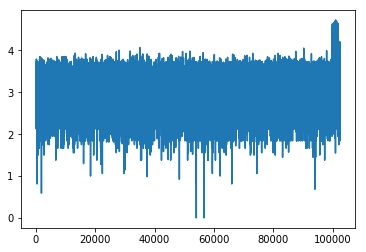

In [26]:
plt.plot(all_domains['entropy'])
plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/shannon/Python_projects/Envs/DGA_detection/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


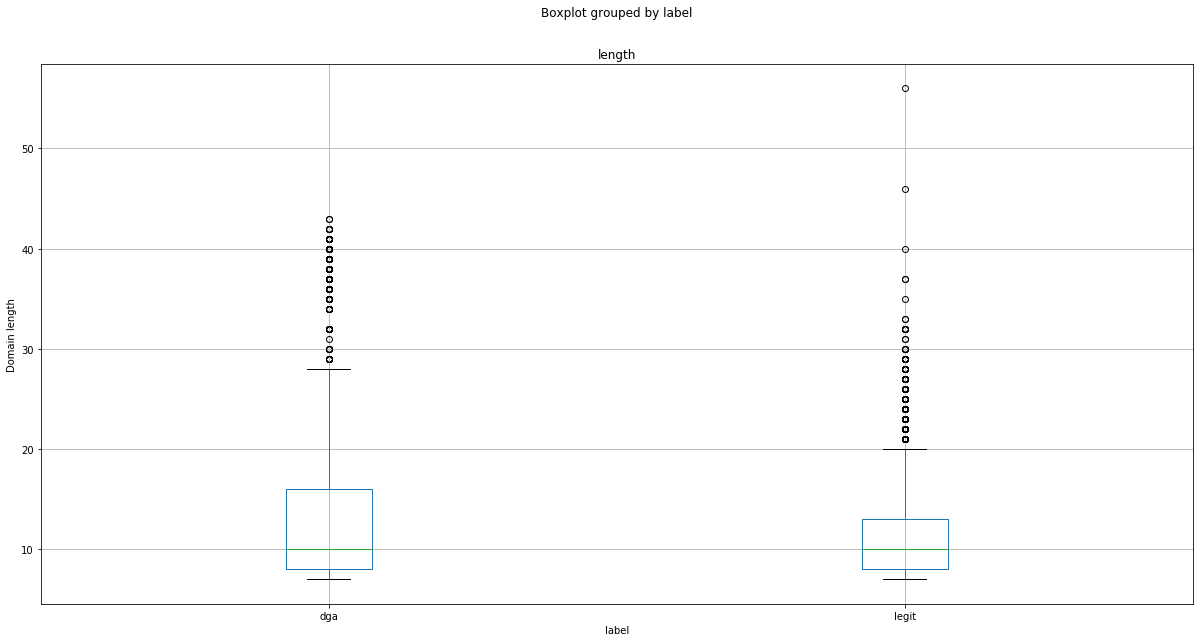

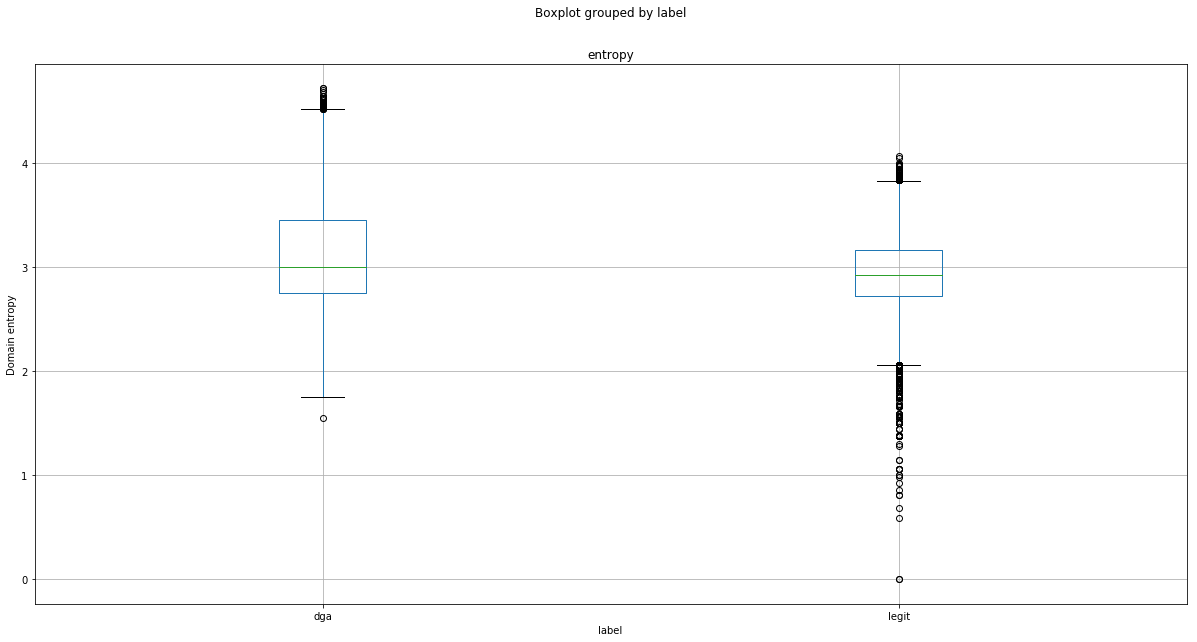

In [27]:
from matplotlib import pylab
from pylab import rcParams
%pylab inline

rcParams['figure.figsize'] = 20, 10
pylab.rcParams['axes.grid'] = True

all_domains.boxplot('length', 'label')
pylab.ylabel('Domain length')

all_domains.boxplot('entropy', 'label')
pylab.ylabel('Domain entropy')


In [28]:
# Split data to dga and legit to do some scatter plots
split_condition = all_domains['label'] == 'legit'
print len(split_condition)
type(split_condition)

74200


pandas.core.series.Series

In [29]:
# dga and non-dga
legit = all_domains[split_condition]
dga = all_domains[~split_condition]
dga.head()

,domain,label,length,entropy
99838,04055051be412eea5a61b7da8438be3d,dga,32,3.569549
99839,1cb8a5f36f,dga,10,3.121928
99840,30acd347397c34fc273e996b22951002,dga,32,3.628928
99841,336c986a284e2b3bc0f69f949cb437cb,dga,32,3.515320
99842,336c986a284e2b3bc0f69f949cb437cb,dga,32,3.515320


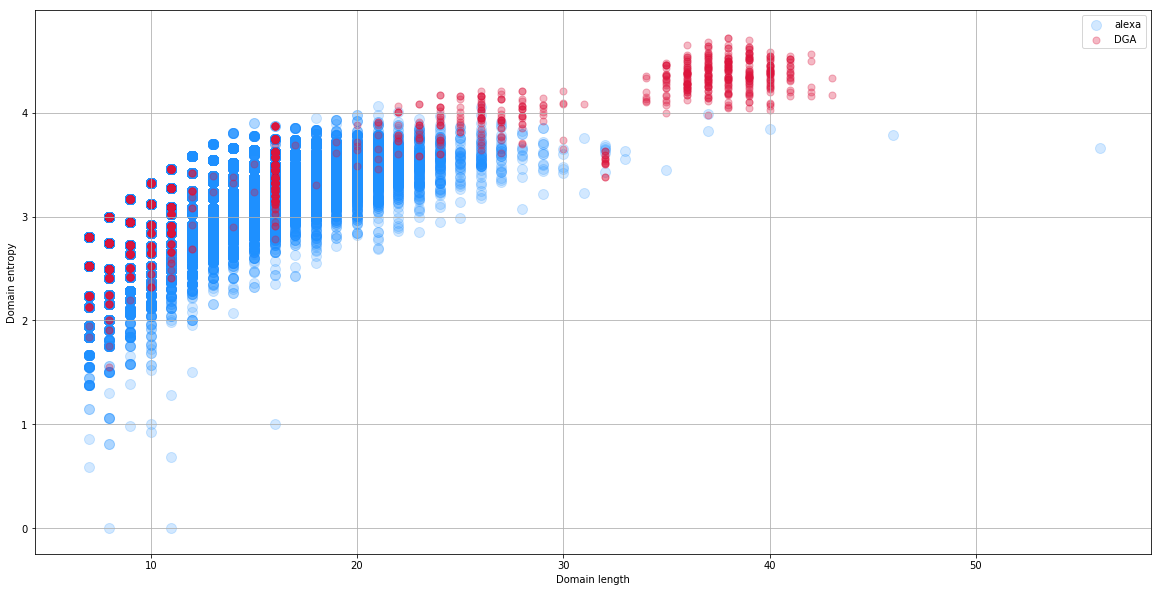

In [30]:
# Do some plots.
plt.scatter(legit['length'], legit['entropy'], s=100, c='dodgerblue', label='alexa', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=50, c='crimson', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain length')
pylab.ylabel('Domain entropy')

In [39]:
# Let's do some statistics.
print 'DGA domains mean'
np.mean(dga)

DGA domains sample stats


length     14.142001
entropy     3.160549
dtype: float64

In [38]:
print 'DGA domains standard deviation'
np.std(dga)

length     9.799052
entropy    0.592015
dtype: float64

In [36]:
print 'Legit domains mean'
np.mean(legit)

Legit domains sample stats


length     10.769359
entropy     2.922003
dtype: float64

In [41]:
print 'Legit domains standard deviation'
np.std(legit)

Legit domains standard deviation


length     3.363548
entropy    0.345285
dtype: float64

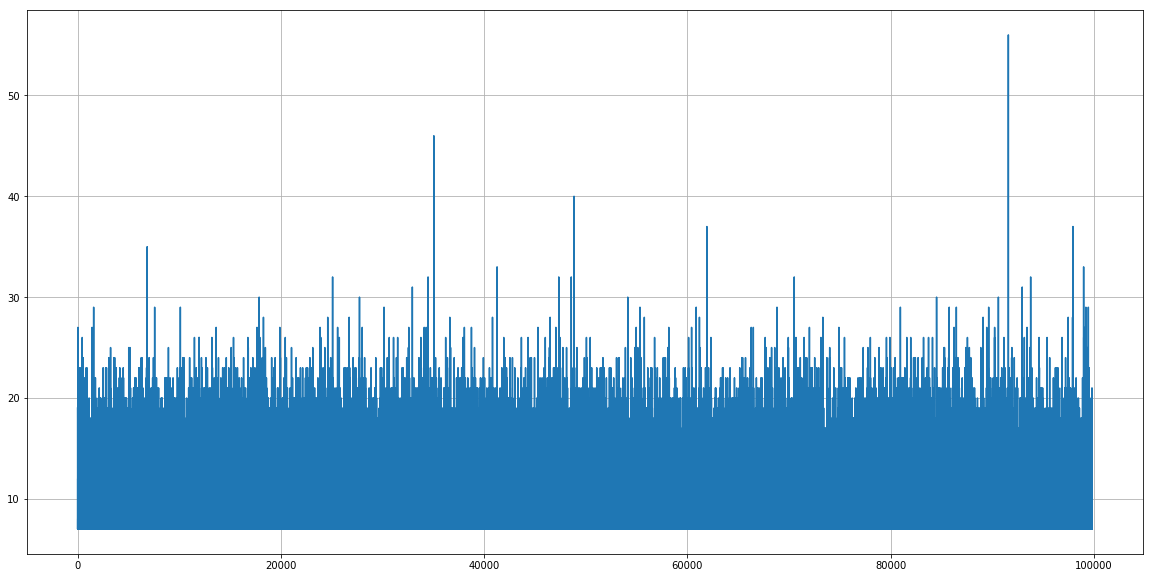

In [43]:
plt.plot(legit['length'])

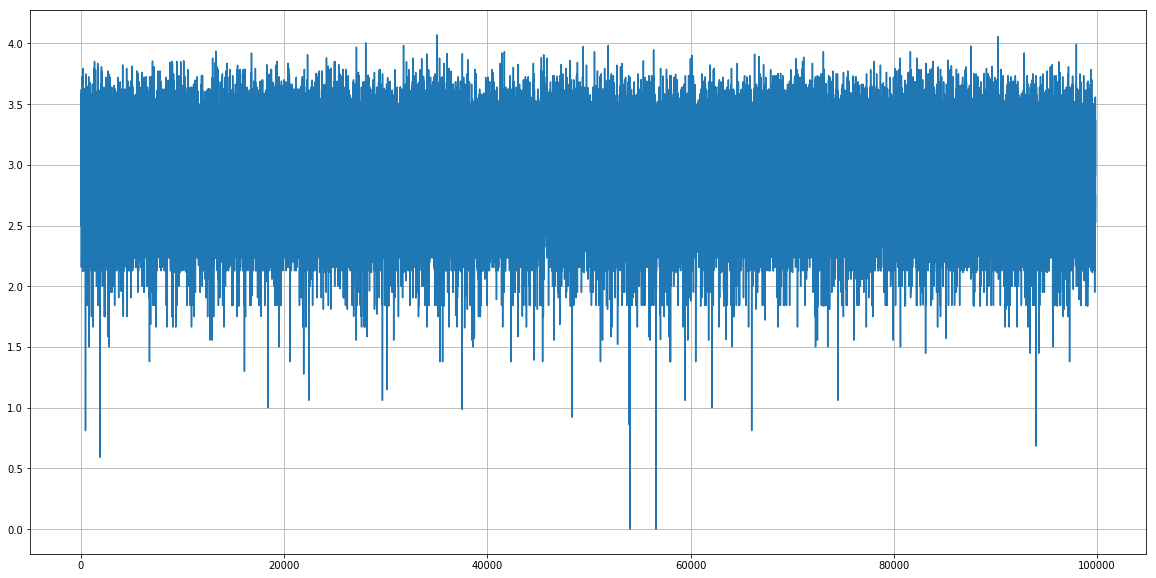

In [44]:
plt.plot(legit['entropy'])

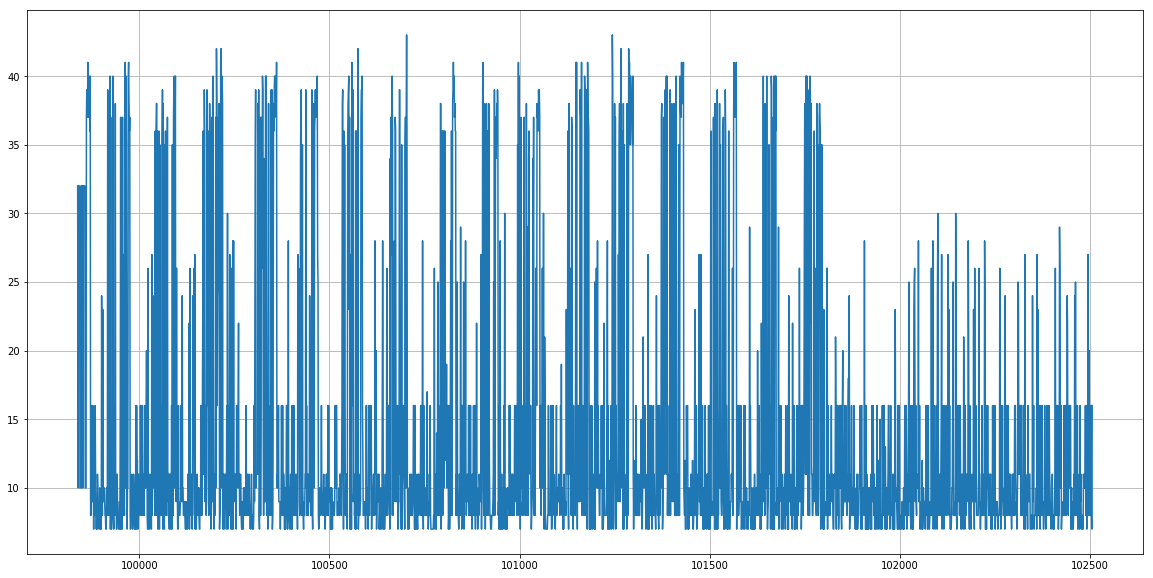

In [45]:
plt.plot(dga['length'])

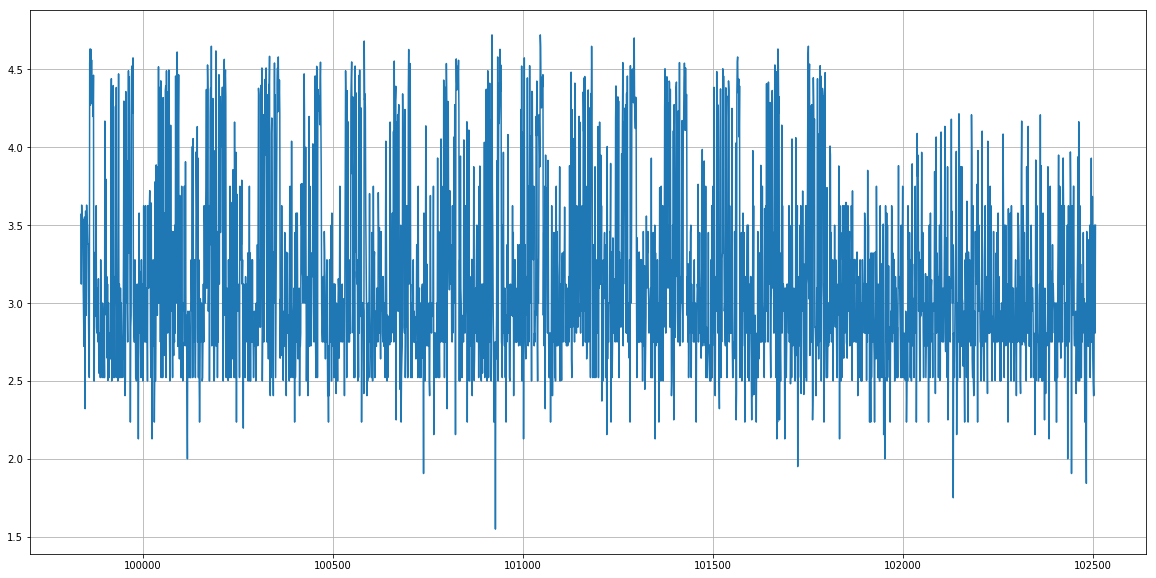

In [47]:
plt.plot(dga['entropy'])

In [53]:
import sklearn.ensemble
# Okay let's make use of some ML algorithms... what about RandomForests ?
X = all_domains.as_matrix(['length', 'entropy'])
y = np.array(all_domains['label'].tolist())

In [57]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)

In [60]:
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=5, n_jobs=4)
print scores

[ 0.97129573  0.96947439  0.9717655   0.96772237  0.9656985 ]


In [65]:
# Verify accuracy of the model by doing test and train sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print y_pred

['legit' 'legit' 'legit' ..., 'legit' 'legit' 'legit']


Confusion Matrix Stats
legit/legit: 99.87% (14286/14304)
legit/dga: 0.13% (18/14304)
dga/legit: 83.40% (447/536)
dga/dga: 16.60% (89/536)


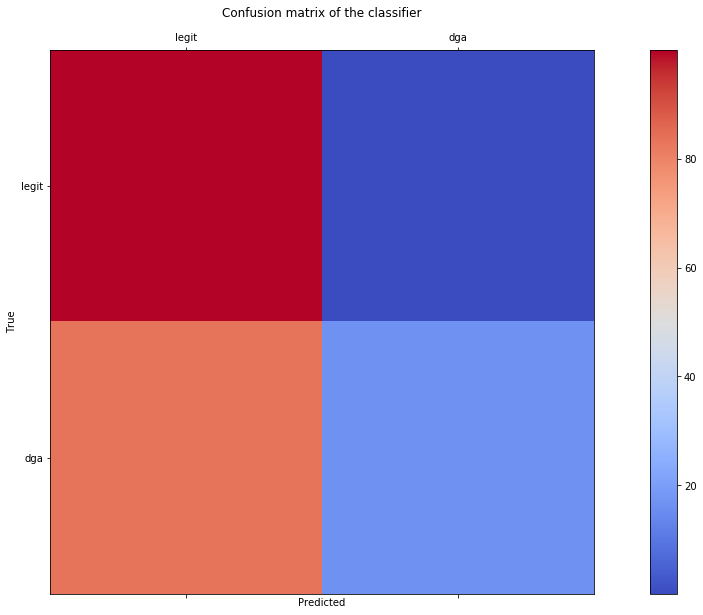

In [70]:
# Use confusion matrix to view the results.
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)
    
    print 'Confusion Matrix Stats'
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print "%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum())

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicted')
    pylab.ylabel('True')
    pylab.show()

plot_cm(cm, labels)


In [71]:
'''The model is biased, classifies almost everything as legit! 
that's due to the unbalance of dga records and alexa records '''

"The model is biased, classifies almost everything as legit! \nthat's due to the unbalance of dga records and alexa records "

In [72]:
# I'll try SVM just to make sure the data is the problem.
from sklearn import svm

clf2 = svm.SVC()

In [74]:
clf2.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
svm_result = clf2.predict(X_test)
svm_result

array(['legit', 'legit', 'legit', ..., 'legit', 'legit', 'legit'], 
      dtype='|S5')

Confusion Matrix Stats
legit/legit: 99.93% (14294/14304)
legit/dga: 0.07% (10/14304)
dga/legit: 85.63% (459/536)
dga/dga: 14.37% (77/536)


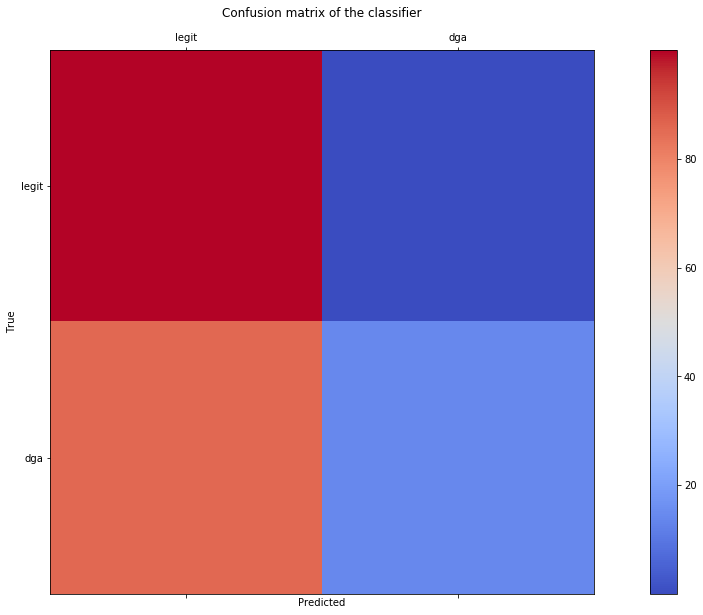

In [77]:
cm2 = confusion_matrix(y_test, svm_result, labels)
plot_cm(cm2, labels)

In [ ]:
# We notice that we still have the same problem, maybe worst we have more false negatives.